**<font size="+1">Nhận dạng hình ảnh chữ viết tay bằng mô hình ANN</font>**

1. Khai báo các thư viện cần thiết

In [1]:
import os
import numpy as np
import gzip
import time

2. Khai báo đường dẫn đến tệp dữ liệu

In [2]:
data_path = '../../data/'
train_images_path = os.path.join(data_path, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_path, 'train-labels-idx1-ubyte.gz')

test_images_path = os.path.join(data_path, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_path, 't10k-labels-idx1-ubyte.gz')

3. Định nghĩa hàm `get_mnist_data` để tải dữ liệu từ tệp gzip chứa hình ảnh và nhãn của bộ dữ liệu

In [3]:
def get_mnist_data(images_path, labels_path, num_images, shuffle=False, _is=True, image_size=28):
    f_images = gzip.open(images_path,'r')
    f_images.read(16)
   
    real_num = num_images if not shuffle else (60000 if _is else 10000)
    buf_images = f_images.read(image_size * image_size * real_num)

    images = np.frombuffer(buf_images, dtype=np.uint8).astype(np.float32)
    images = images.reshape(real_num, image_size, image_size,)

    f_labels = gzip.open(labels_path,'r')
    f_labels.read(8)
    labels = np.zeros((real_num)).astype(np.int64)

    for i in range(0, real_num):
        buf_labels = f_labels.read(1)
        labels[i] = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64)

    if shuffle is True:
        rand_id = np.random.randint(real_num, size=num_images)
        images = images[rand_id, :]
        labels = labels[rand_id,]

    images = images.reshape(num_images, image_size * image_size)
    return images, labels

4. Sử dụng hàm `get_mnist_data` lấy dữ liệu train, test từ tệp dữ liệu

In [4]:
train_images, train_labels = get_mnist_data(
    train_images_path, train_labels_path, 60000)
test_images, test_labels = get_mnist_data(
    test_images_path, test_labels_path, 10000, _is=False)
print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

C:\Users\dangngocquan\AppData\Local\Temp\ipykernel_4144\2761624895.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels[i] = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64)


(60000, 784) (60000,)
(10000, 784) (10000,)


5. Chuẩn hóa dữ liệu

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_x = scaler.fit_transform(train_images)
test_x = scaler.fit_transform(test_images)

print(train_x.shape)
print(test_x.shape)

(60000, 784)
(10000, 784)


6. Sử dụng phương pháp PCA giảm số chiều dữ liệu về 100 chiều

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
pca.fit(train_images)
X_train = pca.transform(train_images)
X_test = pca.transform(test_images)

print(X_train.shape)
print(X_test.shape)

(60000, 100)
(10000, 100)


7. Khởi tạo và xây dựng mô hình ANN

In [7]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

model = Sequential()

model.add(Flatten(input_shape = (100,)))
model.add(Dense(128,activation = 'relu'))
model.add(Dense(64,activation = 'relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(10,activation = 'softmax')) 

g:\app\python\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8. Tổng quan kiến trúc mô hình

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,594 (92.16 KB)

 Trainable params: 23,594 (92.16 KB)

 Non-trainable params: 0 (0.00 B)

9. Biên soạn mô hình với hàm mất mát `sparse_categorical_crossentropy`, thuật toán tối ưu `Adam`, độ đo huấn luyện `accuracy`

In [9]:
model.compile(loss = 'sparse_categorical_crossentropy', 
              optimizer = 'Adam', 
              metrics = ['accuracy'])

10. Huấn luyện mô hình bằng tập dữ liệu train

In [10]:
start_time = time.time()

model.fit(X_train, train_labels, epochs= 10 , validation_split = .2)

end_time = time.time()

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6471 - loss: 9.9099 - val_accuracy: 0.8345 - val_loss: 0.5852
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8767 - loss: 0.4651 - val_accuracy: 0.8988 - val_loss: 0.3787
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9180 - loss: 0.2916 - val_accuracy: 0.9264 - val_loss: 0.3012
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9359 - loss: 0.2253 - val_accuracy: 0.9378 - val_loss: 0.2304
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9518 - loss: 0.1701 - val_accuracy: 0.9489 - val_loss: 0.2048
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9617 - loss: 0.1319 - val_accuracy: 0.9537 - val_loss: 0.1863
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9697 - loss: 0.1118 - val_accuracy: 0.9558 - val_loss: 0.1666
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9733 - loss: 0.0900 - 

11. Sử dụng mô hình đã huấn luyện dự đoán tập dữ liệu test

In [11]:
pred_labels = model.predict(X_test)
pred_labels = pred_labels.argmax(axis = 1)
print(pred_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[7 2 1 ... 4 5 6]


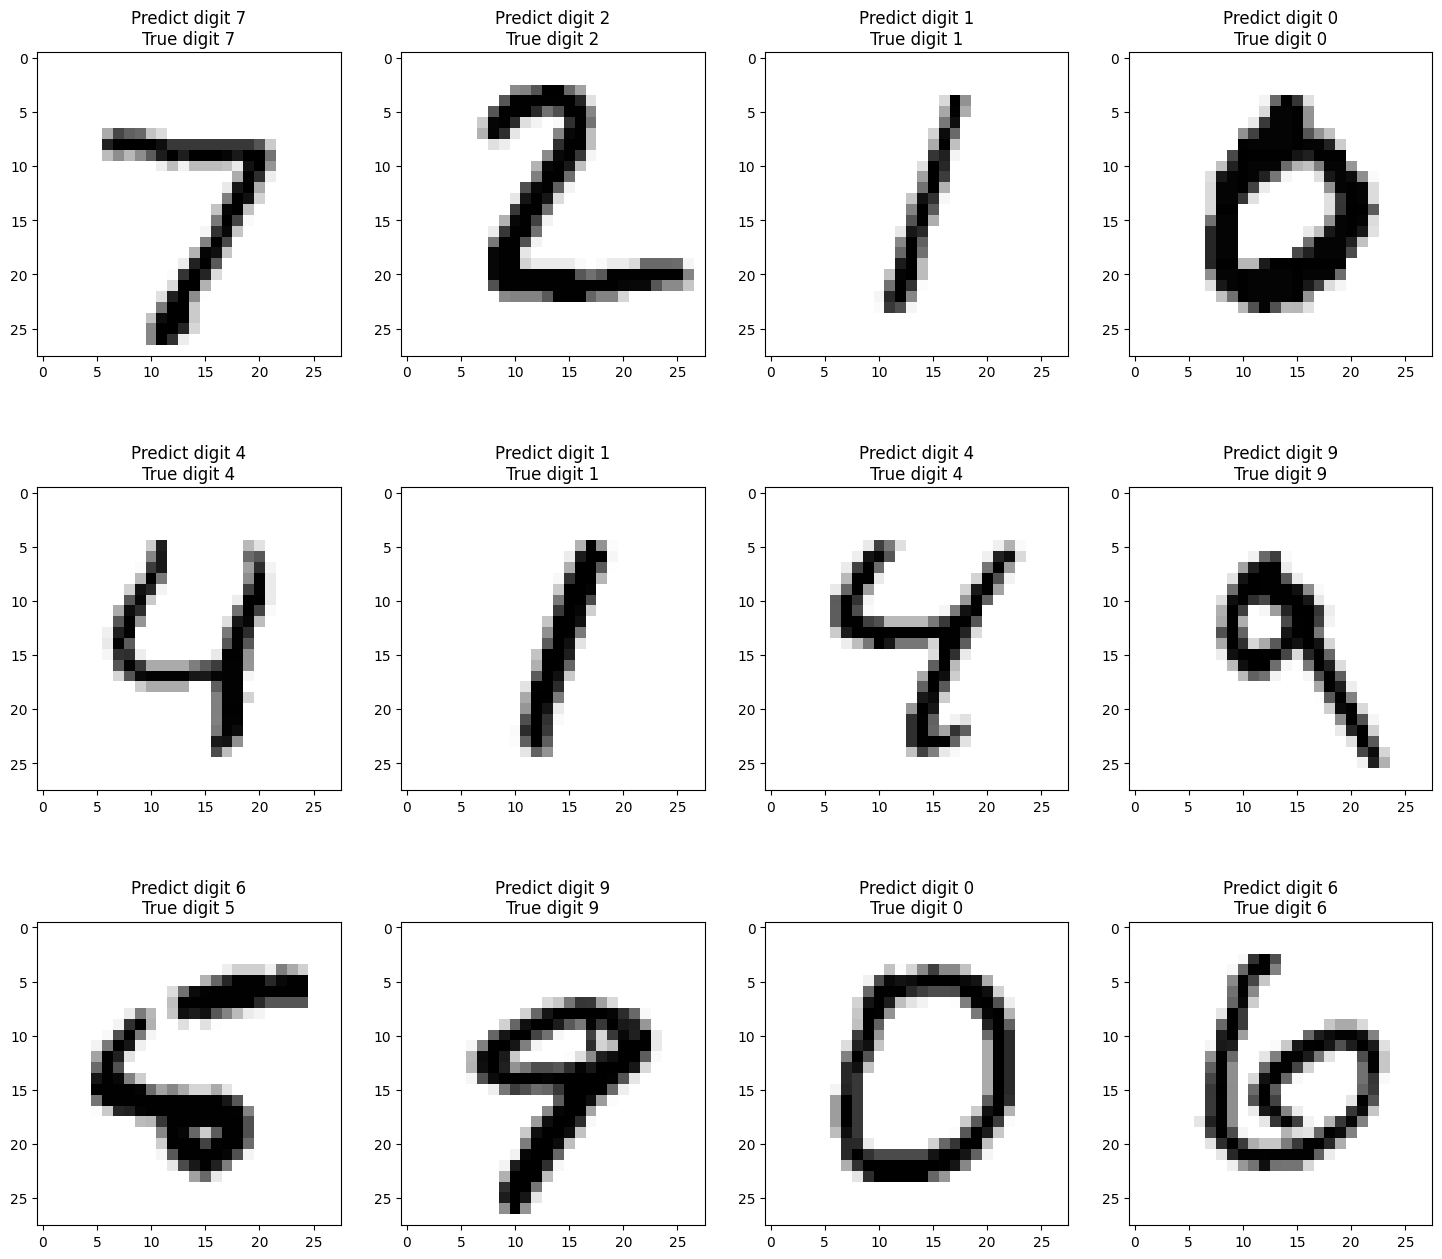

In [12]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(3, 4, figsize=(18, 16))

for i, ax in enumerate(axis.flat):
    ax.imshow(test_images[i].reshape(28, 28), cmap='binary')
    ax.set(title = "Predict digit {0}\nTrue digit {1}".format(pred_labels[i], test_labels[i]))

12. Tính các chỉ số `accuray`, `confusion matrix`, `precision`, `recall` của mô hình

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

train_time = end_time - start_time
print("Train time: ", train_time)

accuracy = accuracy_score(test_labels, pred_labels)
print("Accuracy:", accuracy)

confusion_matrix = confusion_matrix(test_labels, pred_labels)
print("Confusion Matrix:")
print(confusion_matrix)

precision = precision_score(test_labels, pred_labels, average='macro')
print("Precision:", precision)

recall = recall_score(test_labels, pred_labels, average='macro')
print("Recall:", recall)

Train time:  27.205636739730835
Accuracy: 0.9623
Confusion Matrix:
[[ 943    0    8    1    0    0   22    1    4    1]
 [   0 1109    4    2    1    0    7    7    5    0]
 [   0    1 1009    2    1    0    3    8    7    1]
 [   0    0   15  954    0    5    0    4   29    3]
 [   1    0    7    0  946    0    8    1    1   18]
 [   2    0    0   16    1  823   12    2   30    6]
 [   3    3    0    0    3    4  940    0    5    0]
 [   1    5   12    1    8    0    0  993    4    4]
 [   0    0    4    6    2    0    3    2  950    7]
 [   2    2    5    5   11    3    1   15    9  956]]
Precision: 0.9628331898677269
Recall: 0.9617587156373496


**Đánh giá tổng quan mô hình:<br>**
+ `Train time`: 18.0978 giây
+ `Accuracy` của mô hình khoảng 96.76%, tức là khoảng 96.37% các dự đoán được thực hiện đúng trên tập dữ liệu kiểm tra. Đây là một kết quả tốt<br>
+ `Confusion Matrix` cung cấp thông tin chi tiết về các dự đoán của mỗi lớp. Số liệu trên đường chéo chính của ma trận đều cao và sấp sỉ nhau. Từ đây, ta thấy rằng mô hình dự đoán phân loại các lớp khá tốt, với số lượng nhầm lẫn rất ít.<br>
+ `Precision`trung bình của mô hình khoảng 96.78%, tức là trung bình tỷ lệ giữa số lượng dự đoán đúng của một lớp trên tổng số lần dự đoán cho lớp đó là 96.78%. Điều này cho thấy việc dự đoán của mô hình có độ chính xác tốt, đáng tin cậy.<br>
+ `Recall` trung bình của mô hình là khoảng 96.73%, tức là trung bình tỷ lệ giữa số lượng dự đoán đúng của một lớp trên tổng số lần lớp đó thực sự xuất hiện trong dữ liệu là 96.73%. Điều này cho thấy mô hình có khả năng nhận diện đúng hầu hết các mẫu thực sự thuộc vào mỗi lớp.<br>

Nhìn chung, chương trình đạt được hiệu suất tốt trong việc phân loại hình ảnh chữ viết tay bằng việc sử dụng mô hình ANN kết hợp với kỹ thuật giảm chiều dữ liệu PCA. Điều này cho thấy mô hình đã "học" một cách khá hiệu quả và có thể tin cậy khi sử dụng để phân loại các hình ảnh chữ số viết tay<br>